In [1]:
%load_ext autoreload
%autoreload 2

### SetUp

In [1]:
# !git clone https://github.com/InesVATI/active_contour_cnn.git

# %cd active_contour_cnn/src
# %ls

In [1]:
# !pip install pydicom

In [34]:
import pydicom as dicom
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
from typing import Literal
import time

from models import LayerFCN8
from datasets import save_multilayer_label_map, CHAOSDataset

root_dir = os.path.dirname(os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cpu


In [35]:
data_folder = os.path.join(root_dir, '__data', 'Train_Sets', 'CT')
test_data_folder = os.path.join(root_dir, '__data', 'Test_Sets')
result_folder = f'{root_dir}/__results/'
figure_folder = f'{root_dir}/figures'

In [36]:
generate_gt_layered_map = False
if generate_gt_layered_map:
    save_multilayer_label_map(data_folder, d=5)

## ACM

In [6]:
# !pip install scikit-fmm # for re-distancing # in colab
# %pip install scikit-fmm # jupyter notebook

In [37]:
import MVA_geodesic_methods.nt_toolbox.grad as toolgrad
import MVA_geodesic_methods.nt_toolbox.div as tooldiv

from MVA_geodesic_methods.nt_toolbox.plot_levelset import plot_levelset

from MVA_geodesic_methods.nt_toolbox.perform_redistancing import perform_redistancing

from scipy import signal

In [27]:
# Load test data
patient_ids = os.listdir(os.path.join(test_data_folder))
test_dicom_files = []
test_layer_label_map_files = []
for id in patient_ids:
    test_dicom_files += ["/".join([id, 'DICOM_anon', name]) for name in os.listdir(os.path.join(test_data_folder, id, 'DICOM_anon'))]
    test_layer_label_map_files += ["/".join([id, 'Layer_label_map', name]) for name in os.listdir(os.path.join(test_data_folder, id, 'Layer_label_map'))]
print(test_dicom_files)
print(test_layer_label_map_files)

['14/DICOM_anon/i0012,0000b.dcm', '14/DICOM_anon/i0013,0000b.dcm', '14/DICOM_anon/i0014,0000b.dcm', '26/DICOM_anon/IMG-0009-00028.dcm', '26/DICOM_anon/IMG-0009-00032.dcm', '26/DICOM_anon/IMG-0009-00033.dcm']
['14/Layer_label_map/GT_map_012.npy', '14/Layer_label_map/GT_map_013.npy', '14/Layer_label_map/GT_map_014.npy', '26/Layer_label_map/GT_map_028.npy', '26/Layer_label_map/GT_map_032.npy', '26/Layer_label_map/GT_map_033.npy']


In [32]:
def normalize_img(dicom_img):
    img_min, img_max = dicom_img.min(), dicom_img.max()
    img = (dicom_img - img_min) / (img_max - img_min)
    return img

def convert_to_RGB(oneC_img):
    imgRGB = torch.tensor(oneC_img, dtype=torch.float32)
    imgRGB = imgRGB.expand(3, -1, -1).contiguous()
    return imgRGB

In [46]:
def get_initial_levelset(layer_label_map, threshold : int = 0):
    seg_map = np.where(layer_label_map <= threshold, 1, 0)
    phi0 = ndimage.distance_transform_edt(1 - seg_map) - ndimage.distance_transform_edt(seg_map)
    return phi0

### Compute model's output

In [30]:
def get_predicted_layer_label_map(output : torch.tensor, nclass=7) -> np.ndarray:
  """
  Convert model's output with value in {0, nclass-1} to value in {-n/2, ..., 0, ..., n/2}
  corresponding to layer index
  :param output: model's output of size (1, nclass, H, W)
  """
  pred_label_map = torch.argmax(output.squeeze(0), dim=0)
  t = int((nclass-1)/2)
  label_map = (pred_label_map - t).detach().numpy()

  return label_map

In [31]:
# Extract initial curve from FCN model output
saved_modelFCN = LayerFCN8()
saved_modelFCN.load_state_dict(torch.load(f'{result_folder}/modelFCN8_retrained_e100.pth', map_location=device))
saved_modelFCN.eval()

LayerFCN8(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_si

For image 2, some artifacts are present. For instance, few pixels (1 to 2) take huge values (>$1.10^4$). In this case, we preprocessed by divided those values by 10 so the image is exploitable.

In [72]:
img_id = 4
with open(os.path.join(test_data_folder, test_layer_label_map_files[img_id]), 'rb') as f:
    gt_label_map = np.load(f)
with open(os.path.join(test_data_folder, test_dicom_files[img_id]), 'rb') as f:
    ds = dicom.dcmread(f)
    img = ds.pixel_array

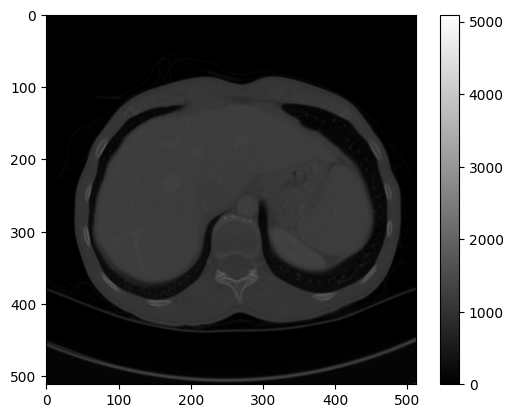

In [39]:
# only for image 1 to 3
if img_id < 3:
    lim = 1e4
    img_h = np.where(img>lim, img/10, img)
    plt.imshow(img_h, cmap='gray')
    plt.colorbar()

    img = normalize_img(img_h)

In [40]:
imgRGB = convert_to_RGB(img)
output = saved_modelFCN(imgRGB.unsqueeze(0).to(device))
print('out', output.shape)
pred_label_map = get_predicted_layer_label_map(output)
print('label_map', pred_label_map.shape)
print(np.unique(pred_label_map, return_counts=True))

out torch.Size([1, 7, 512, 512])
label_map (512, 512)
(array([-3, -2, -1,  0,  1,  2,  3], dtype=int64), array([ 14490,   5637,   4759,   2009,   2760,  24527, 207962],
      dtype=int64))


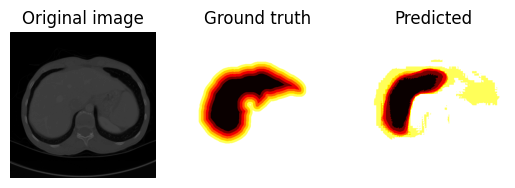

In [49]:
fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(gt_label_map, cmap='hot')
plt.axis('off')
plt.title('Ground truth')

plt.subplot(1, 3, 3)
plt.imshow(pred_label_map.squeeze(), cmap='hot')
plt.axis('off')
plt.title('Predicted')


fig.savefig(f'{figure_folder}/ex_bad_case.png', bbox_inches='tight')

phi0 (512, 512) (512, 512)


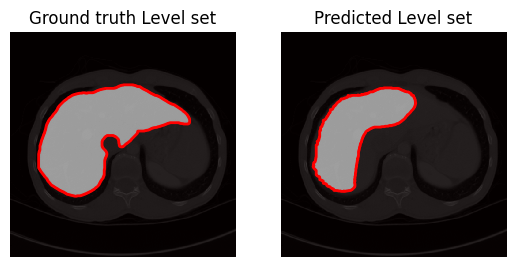

In [53]:
gt_phi0 = get_initial_levelset(gt_label_map)
pred_phi0 = get_initial_levelset(pred_label_map)
print('phi0', gt_phi0.shape, pred_phi0.shape)

fig = plt.figure()
plt.subplot(1, 2, 1)
plot_levelset(gt_phi0, 0, img)
plt.imshow(gt_label_map<=0, cmap='hot', alpha=.5)
plt.title('Ground truth Level set')
plt.subplot(1, 2, 2)
plot_levelset(pred_phi0, 0, img)
plt.imshow(pred_label_map<=0, cmap='hot', alpha=.5)
plt.title('Predicted Level set')

fig.savefig(f'{figure_folder}/ex_bad_case_levelset.png', bbox_inches='tight')

### Implement ACM resolution

In [55]:
def compute_local_mean(img : np.ndarray, phi : np.ndarray, r: int = 3):
    # local_mean = ndimage.uniform_filter(img, size=r, mode='mirror')
    int_img = np.where(phi <= 0, img, 0)
    ext_img = np.where(phi > 0, img, 0)
    kernel = np.ones((r, r))
    local_mean_int = signal.convolve2d(int_img, kernel, mode='same', boundary='symm')
    local_mean_ext = signal.convolve2d(ext_img, kernel, mode='same', boundary='symm')

    mleft = (r-1)//2
    if r %2 == 0:
        mright = mleft + 1 
    else :
        mright = mleft
    x, y = np.meshgrid( np.arange(-mleft, mright+1), np.arange(-mleft, mright+1))
    pad = r-1
    c = pad//2
    if pad %2 == 0:
        pad_phi = np.pad(phi, ((c, c), (c, c)), mode='symmetric')
    else :
        pad_phi = np.pad(phi, ((c, c+1), (c, c+1)), mode='symmetric')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            px = (y + i + mleft, x + j + mleft)
            nint = (pad_phi[px]<= 0).sum()
            next = (pad_phi[px] > 0).sum()
            assert nint <= r**2
            assert next <= r**2
            if next > 0:
                local_mean_ext[i, j] /= next
                # print('next', next)
            if nint > 0:
                local_mean_int[i, j] /= nint
                # print('nint', nint) 


    return local_mean_int, local_mean_ext

def compute_global_mean(img : np.ndarray, phi : np.ndarray):
    cst_int = np.mean(img[phi<=0])
    cst_ext = np.mean(img[phi>0])

    return cst_int, cst_ext

In [56]:
def compute_edge_info(img, kernel_size=60, sigma=.05):

    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    kernel = np.exp(- (((x-1)/kernel_size - .5)**2 + ((y-1)/kernel_size-.5)**2)/ (4*sigma**2))/sigma
    smooth_img = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    grad_smooth = toolgrad.grad(smooth_img, order=2)
    norm_grad_smooth = np.sqrt( np.sum(grad_smooth**2, 2))

    epsilon = 1e-1
    W = 1./(epsilon + norm_grad_smooth)

    # rescale W
    wmin, wmax = W.min(), W.max()
    W = (W - wmin )*.99 / (wmax - wmin) + .01
    grad_W = toolgrad.grad(W, order=2)
    return W, grad_W

In [70]:
def solve_acm(img : np.ndarray, 
              layer_label_map : np.ndarray,
              phi0 : np.ndarray,
              tau : float = .5,
              niter: int = 500,
              redistancing_occur : int = 10,
              weights : list = None,
              chan_vese : Literal['Local', 'Global'] = None,
              local_region_r : int = 8,
              polynomial_fcn_force_order : int = None, 
              add_edge_info: bool = False,
              verbose : bool = False,
              verbose_nrep : int = 200,
              fig_id: str = 'ex'):
    """
    Iterative algorithm to solve the Euler Lagrange equation associated with level set formalism

    :param redistancing_occur: int, re-distancing of $\phi$ is performed every redistancing_occur iteration 
    :param local_region_r: int, local region radius to compute the local region-based energy when chan_vese is 'Local', 
    :param polynomial_fcn_force_order: int, If None (default), the strength of the steering force from the FCN 
                     : has an exponential relationship with its distance to the boundary 
    :param verbose : bool, plot figures for verification 
    """
    eps = np.finfo(float).eps

    config = ''
    if chan_vese:
        assert chan_vese.lower() in ['local', 'global'], f'{chan_vese} Chan Vese is not recognized. chan_vese is either "local" or "global"'
        r = "r%d"%(local_region_r) if chan_vese.lower() == 'local' else ""
        config += f"_CV{chan_vese.lower()}_{r}"

    if weights is None:
        weights = [0.6, .4]
        if chan_vese:
            weights += [1.0]
    else :
        if chan_vese: # if user chooses to add region-based energy, check the weights list has the correct length
            assert len(weights) >= 3, f'For {chan_vese} region-based Chan Vese energy, not enough weigths to balance the forces.'
    config += f'_w{weights}'

    # Precompute F_FCN
    if polynomial_fcn_force_order :
        assert polynomial_fcn_force_order >= 1
        F_FCN = np.sign(layer_label_map) * np.abs(layer_label_map)**polynomial_fcn_force_order
        config += f'_FCNorder{polynomial_fcn_force_order}'
    else :
        F_FCN = np.sign(layer_label_map) * np.exp(np.abs(layer_label_map))
        F_FCN /= (np.sqrt(np.sum(F_FCN**2)) + eps)# normalize the strength
        config += '_FCNexp'

    if verbose:
        plt.imshow(F_FCN)
        plt.title('$F_{FCN}$')
        plt.axis('off')
        plt.colorbar()
        plt.show()

    # Add edge information
    if add_edge_info:
        W, grad_W = compute_edge_info(img)
        config += '_edgeInfo'
    else :
        W = 1.

    if verbose and add_edge_info:
        plt.subplot(1, 2, 1)
        plt.imshow(W, cmap='seismic')
        plt.axis('off')
        plt.colorbar()
        plt.title('W')
        plt.subplot(1, 2, 2)
        plt.imshow(grad_W[..., 0])
        plt.title(r'$\nabla W_x$')
        plt.axis('off')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    phi = phi0.copy()

    fig = plt.figure(figsize = (25, 8))

    total_subplots = niter // verbose_nrep
    s = 1
    for i in range(niter):

        # Add internal and FCN forces
        grad_phi = toolgrad.grad(phi, order=2)
        norm_grad_phi = np.sqrt( np.sum(grad_phi**2, 2))
        normal_vect = grad_phi / (norm_grad_phi[..., np.newaxis] + eps)

        curvature = tooldiv.div(normal_vect[..., 0], normal_vect[..., 1], order=2)
        G = - weights[0] * W * norm_grad_phi * curvature - weights[1] * F_FCN 

        if verbose and i%verbose_nrep == 0:
            print('\nIter', i)
            print(f'curvature {curvature.min():.3f} {curvature.max():.3f} mean {curvature.mean():.3f}')
            print(f'norm_grad_phi {norm_grad_phi.min():.3f} {norm_grad_phi.max():.3f} mean {norm_grad_phi.mean():.3f}')
        
        if add_edge_info:
            inner_prod_grad = np.einsum( 'ijk, ijd -> ij', grad_W, grad_phi)
            G = G - weights[0]*inner_prod_grad
            if verbose and i%verbose_nrep == 0:
                print(f'inner_prod_grad {inner_prod_grad.min():.3f} {inner_prod_grad.max():.3f} mean {inner_prod_grad.mean():.3f}')
        
        # Add region-based forces
        if chan_vese:
            args = {'img' : img,
                    'phi' : phi}
            if chan_vese.lower() == 'local':
                args['r'] = local_region_r
            chan_vese_func = eval(f'compute_{chan_vese.lower()}_mean')
            c_int, c_ext = chan_vese_func(**args)
            F_CV = (img - c_ext)**2 - (img - c_int)**2 
            G += weights[2]*F_CV #* approx_delta_phi 

            if verbose and i%verbose_nrep == 0:
                print(f'F_CV {F_CV.min():.3f}, {F_CV.max():.3f} mean {F_CV.mean():.3f}')

        # Gradient descent
        phi = phi - tau*G
        if verbose and i%verbose_nrep == 0:
            print(f'G {G.min():.3f} {G.max():.3f} mean {G.mean():.3f}')
            print(f'phi {phi.min():.3f} {phi.max():.3f} mean {phi.mean():.3f}')

        # re-distancing
        if i % redistancing_occur == 0:
            phi = perform_redistancing(phi)
        if (i+1) % verbose_nrep == 0 :
            fig.add_subplot(1, total_subplots, s)
            plot_levelset(phi, 0, img)
            plt.title('$\phi_{%d}$'%(i))
            s += 1
    fig.tight_layout()
    plt.show()
    fig.savefig(os.path.join(figure_folder, f'{fig_id}_{config}.png'), bbox_inches='tight')
    return phi
        

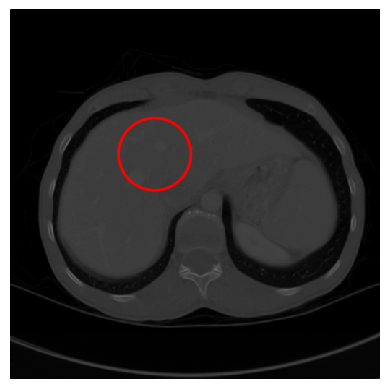

In [68]:
# Define initial level set function
c = np.array([200, 200])
r = 50
w, h = img.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
phi0 = np.sqrt( (X - c[0])**2 + (Y - c[1])**2) - r

plot_levelset(phi0, 0, img)

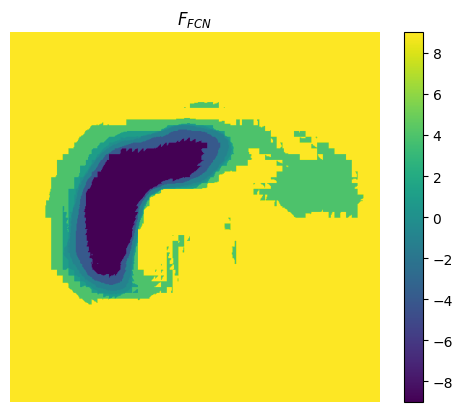


Iter 0
curvature -2.120 2.000 mean 0.000
norm_grad_phi 0.000 1.000 mean 1.000
F_CV -0.047, 0.231 mean -0.018
G -4.742 4.636 mean -3.552
phi -51.835 391.608 mean 157.849

Iter 200
curvature -2.118 1.935 mean 0.000
norm_grad_phi 0.258 518.885 mean 509.618
F_CV -0.048, 0.240 mean -0.018
G -8.222 6.221 mean -3.552
phi -22524.813 199125.566 mean 68432.834

Iter 400
curvature -2.116 1.858 mean -0.000
norm_grad_phi 0.258 520.010 mean 509.032
F_CV -0.049, 0.245 mean -0.018
G -8.216 6.201 mean -3.550
phi -23654.884 198438.906 mean 61591.087

Iter 600
curvature -2.124 1.785 mean 0.000
norm_grad_phi 0.258 518.890 mean 508.603
F_CV -0.049, 0.249 mean -0.018
G -8.218 6.207 mean -3.550
phi -23896.662 197168.103 mean 57507.828

Iter 800
curvature -2.113 1.785 mean 0.000
norm_grad_phi 0.258 519.572 mean 508.367
F_CV -0.050, 0.252 mean -0.018
G -8.220 6.211 mean -3.550
phi -23896.667 196445.921 mean 55633.695


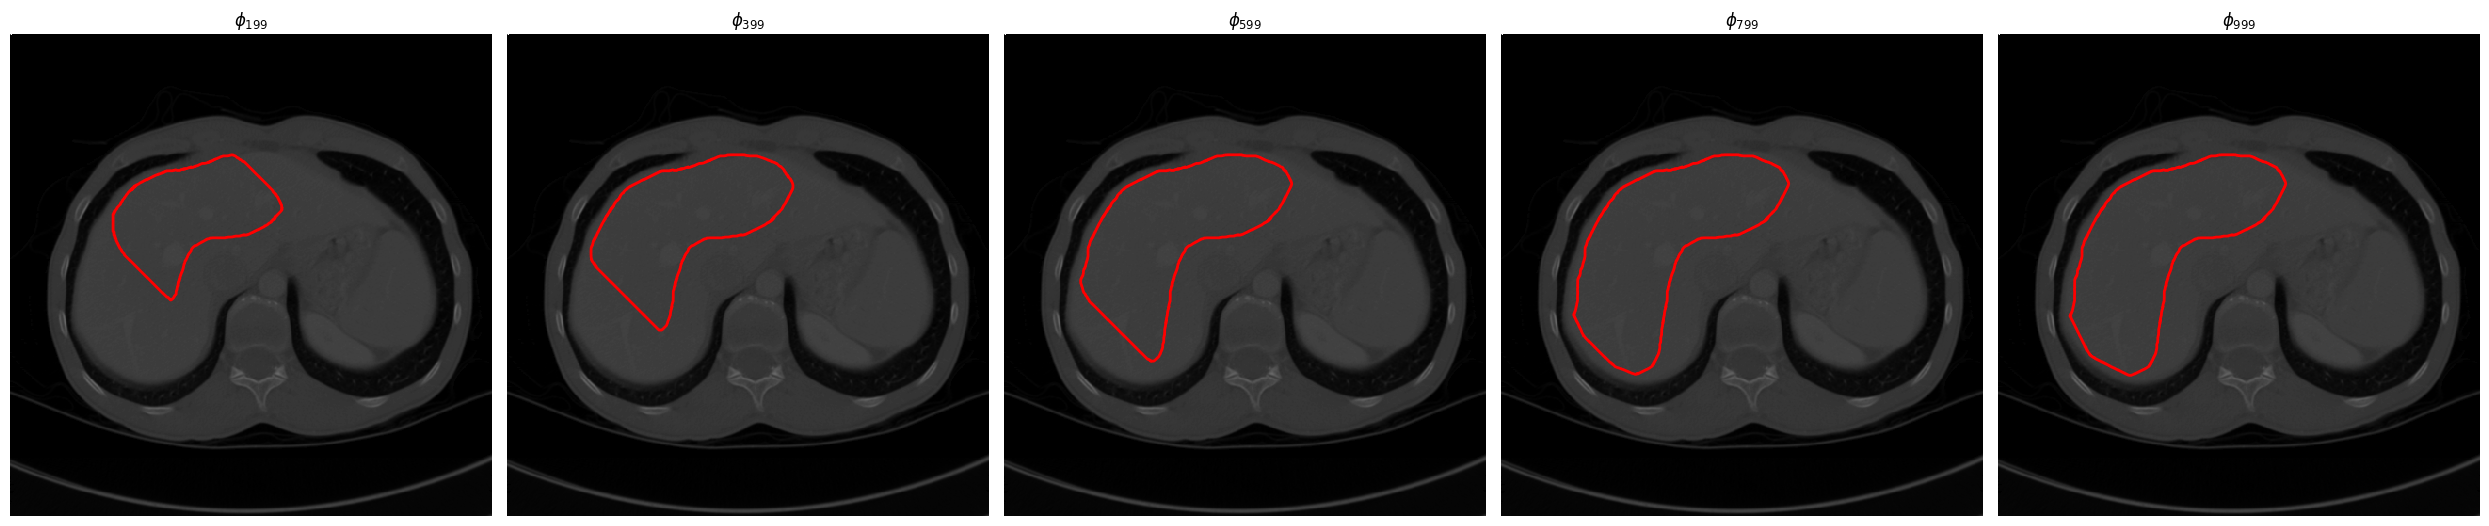

In [71]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.01, .5, 5],
                chan_vese='global',
                # local_region_r=20,
                polynomial_fcn_force_order=2,
                add_edge_info=False,
                verbose=True,
                verbose_nrep=200,
                fig_id='bad_case')

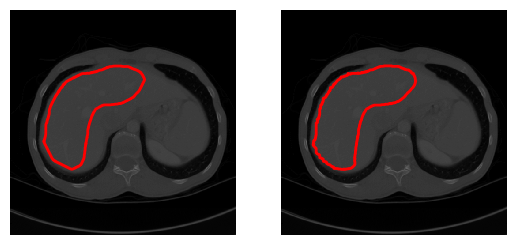

In [67]:
plt.subplot(1, 2, 1)
plot_levelset(phi, 0, img)

plt.subplot(1, 2, 2)
plot_levelset(pred_phi0, 0, img)